In [6]:
%ls

Download_HMP2.ipynb           Prelim_data_analysis.ipynb        README.md
hmp2@                         Prelim_data_analysis_SJBae.ipynb  utils/
hmp2_metadata_2018-08-20.csv  products_MGX_2017-08-12.html


In [17]:
%ls /pool001/robcli/hmp2 | head -n 5

CSM5FZ4M_contigs.fna.gz
CSM5MCUO_contigs.fna.gz
CSM5MCVL_contigs.fna.gz
CSM5MCVN_contigs.fna.gz
CSM5MCW6_contigs.fna.gz
ls: write error: Broken pipe


In [2]:
import utils.parser as parser

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data filtering and sampling

## Import data

In [6]:
sample_df = pd.read_csv("hmp2_metadata_2018-08-20.csv", low_memory=False)

In [7]:
# Get list of filenames in the folder
hmp2_path = "/pool001/robcli/hmp2"
existing_files = os.listdir(hmp2_path)

In [8]:
assembly_df = sample_df.query("data_type == 'metagenomics'").\
              assign(AssemblyName = sample_df["External ID"] + "_contigs.fna.gz")

## QC check

In [1]:
import os
import gzip
import pandas as pd
from Bio import SeqIO
import time

In [2]:
# 🗂️ 1. Define the function to extract stats from a FASTA (.fna.gz) file
def get_assembly_stats(fasta_gz_path):
    contig_lengths = []
    total_length = 0
    gc_count = 0

    with gzip.open(fasta_gz_path, "rt") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            seq = record.seq.upper()
            length = len(seq)
            contig_lengths.append(length)
            total_length += length
            gc_count += seq.count("G") + seq.count("C")

    if not contig_lengths:
        return 0, 0, 0, 0, 0, 0

    contig_count = len(contig_lengths)
    largest_contig = max(contig_lengths)
    gc_content = (gc_count / total_length) * 100 if total_length else 0

    contig_lengths.sort(reverse=True)
    half_total = total_length / 2
    running_sum = 0
    n50 = 0
    l50 = 0

    for i, length in enumerate(contig_lengths):
        running_sum += length
        if running_sum >= half_total:
            n50 = length
            l50 = i + 1
            break

    return contig_count, largest_contig, total_length, round(gc_content, 2), n50, l50

In [3]:
# 📍 2. Path to the directory with your .fna.gz files
assembly_dir = "/pool001/robcli/hmp2"  # <- CHANGE THIS

# 📋 3. Load your metadata.csv (must have "External ID" column)
sampled_df = pd.read_csv("sampled_metadata.csv")

# 🧼 4. Make sure "External ID" column is string and has no file extensions
sampled_df["External ID"] = sampled_df["External ID"].astype(str)

#### Run

In [4]:
# ⏱️ Start timing
start_time = time.time()

# 📦 3. Iterate over all .fna.gz files in the directory
results = []

for filename in os.listdir(assembly_dir):
    if filename.endswith("_contigs.fna.gz"):
        sample_id = filename.replace("_contigs.fna.gz", "")
        fasta_path = os.path.join(assembly_dir, filename)

        if not os.path.isfile(fasta_path):
            print(f"❌ {sample_id}: File not found")
            continue

        try:
            contig_count, largest_contig, total_length, gc_content, n50, l50 = get_assembly_stats(fasta_path)
            results.append({
                "External ID": sample_id,
                "contig_count": contig_count,
                "largest_contig": largest_contig,
                "total_length": total_length,
                "gc_content": gc_content,
                "N50": n50,
                "L50": l50
            })
            print(f"✅ {sample_id}: Stats computed successfully")
        except Exception as e:
            print(f"⚠️ {sample_id}: Error during processing - {e}")
# ⏱️ End timing and report duration
end_time = time.time()

✅ MSM6J2M3: Stats computed successfully
✅ MSM79H7Q: Stats computed successfully
✅ CSM7KON8: Stats computed successfully
✅ PSM7J1BB: Stats computed successfully
✅ MSM79H5M: Stats computed successfully
✅ PSM7J173: Stats computed successfully
✅ CSM5MCXP: Stats computed successfully
✅ CSM7KOU9: Stats computed successfully
✅ HSMA33OV: Stats computed successfully
✅ CSM79HL4: Stats computed successfully
✅ CSMA88CB: Stats computed successfully
✅ MSMA2684: Stats computed successfully
✅ PSM6XBTR: Stats computed successfully
✅ CSM67UFV: Stats computed successfully
✅ CSM67UDJ: Stats computed successfully
✅ HSM7J4JH: Stats computed successfully
✅ PSM7J16U: Stats computed successfully
✅ CSM7KOMB: Stats computed successfully
✅ PSM7J1A8: Stats computed successfully
✅ MSM79H67: Stats computed successfully
✅ PSM7J15G: Stats computed successfully
✅ HSM7J4PG: Stats computed successfully
✅ HSM5MD6A: Stats computed successfully
✅ HSM5MD7O: Stats computed successfully
✅ HSM67VEO: Stats computed successfully


### Ran

In [9]:
elapsed_time = end_time - start_time
print(f"⏱️ Total time taken: {elapsed_time:.2f} seconds")

⏱️ Total time taken: 1689.02 seconds


In [5]:
# 📊 6. Convert results to DataFrame
contig_stats_df = pd.DataFrame(results)
contig_stats_df.to_csv("all_contig_stats.csv", index=False)


In [10]:

# 🔗 7. Merge with metadata
all_metadata_contig_stats = assembly_df.merge(contig_stats_df, on="External ID", how="left")

# 💾 8. Save the updated metadata with new columns
all_metadata_contig_stats.to_csv("all_metadata_contig_stats.csv", index=False)


### Visualize

In [14]:
import matplotlib.pyplot as plt

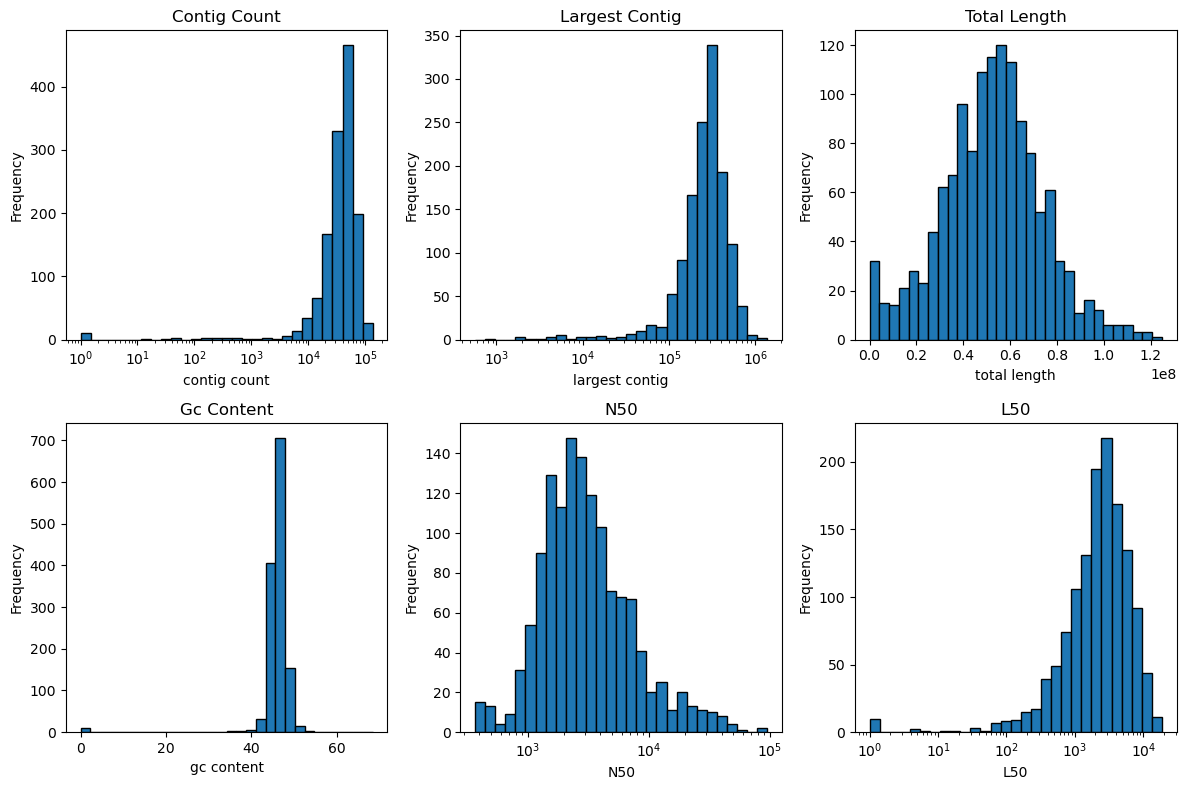

In [18]:
# 📈 6. Plot histograms of characteristics
import numpy as np

plt.figure(figsize=(12, 8))

log_scale_columns = ["contig_count", "largest_contig", "N50", "L50"]

for i, column in enumerate(["contig_count", "largest_contig", "total_length", "gc_content", "N50", "L50"], 1):
    plt.subplot(2, 3, i)
    data = all_metadata_contig_stats[column].dropna()

    if column in log_scale_columns:
        data = data.replace(0, data[data > 0].min())
        bins = np.logspace(np.log10(data.min()), np.log10(data.max()), 30)
        plt.hist(data, bins=bins, edgecolor='black')
        plt.xscale('log')
    else:
        plt.hist(data, bins=30, edgecolor='black')

    plt.title(column.replace("_", " ").title())
    plt.xlabel(column.replace("_", " "))
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("contig_stats_histograms.png")
plt.show()

In [28]:
# 📈 6. Plot histograms of characteristics
import numpy as np

# Filter the DataFrame for contig_count >= 10000
filtered_stats_df = all_metadata_contig_stats[all_metadata_contig_stats["contig_count"] >= 10000]

dropped = all_metadata_contig_stats[all_metadata_contig_stats["contig_count"] < 10000]
dropped[["Participant ID", "External ID", "diagnosis"]]

,Participant ID,External ID,diagnosis
183,C3013,CSM79HPO,UC
184,C3013,CSM79HPU,UC
186,C3013,CSM7KONU,UC
222,C3016,CSM7KOK3,CD
281,C3022,CSM7KOOR,nonIBD
...,...,...,...
1589,P6028,PSM7J17D,CD
1590,P6028,PSM7J17F,CD
1593,P6028,PSM7J163,CD
1595,P6028,PSMA266C,CD


In [29]:
# Count of dropped samples per diagnosis
sample_counts = dropped["diagnosis"].value_counts()

# Count of unique participants per diagnosis
participant_counts = dropped.groupby("diagnosis")["Participant ID"].nunique()

# Combine into a summary DataFrame
drop_summary = pd.DataFrame({
    "Dropped Samples": sample_counts,
    "Dropped Participants": participant_counts
})

print(drop_summary)


        Dropped Samples  Dropped Participants
CD                   31                    15
UC                   28                    10
nonIBD                5                     3


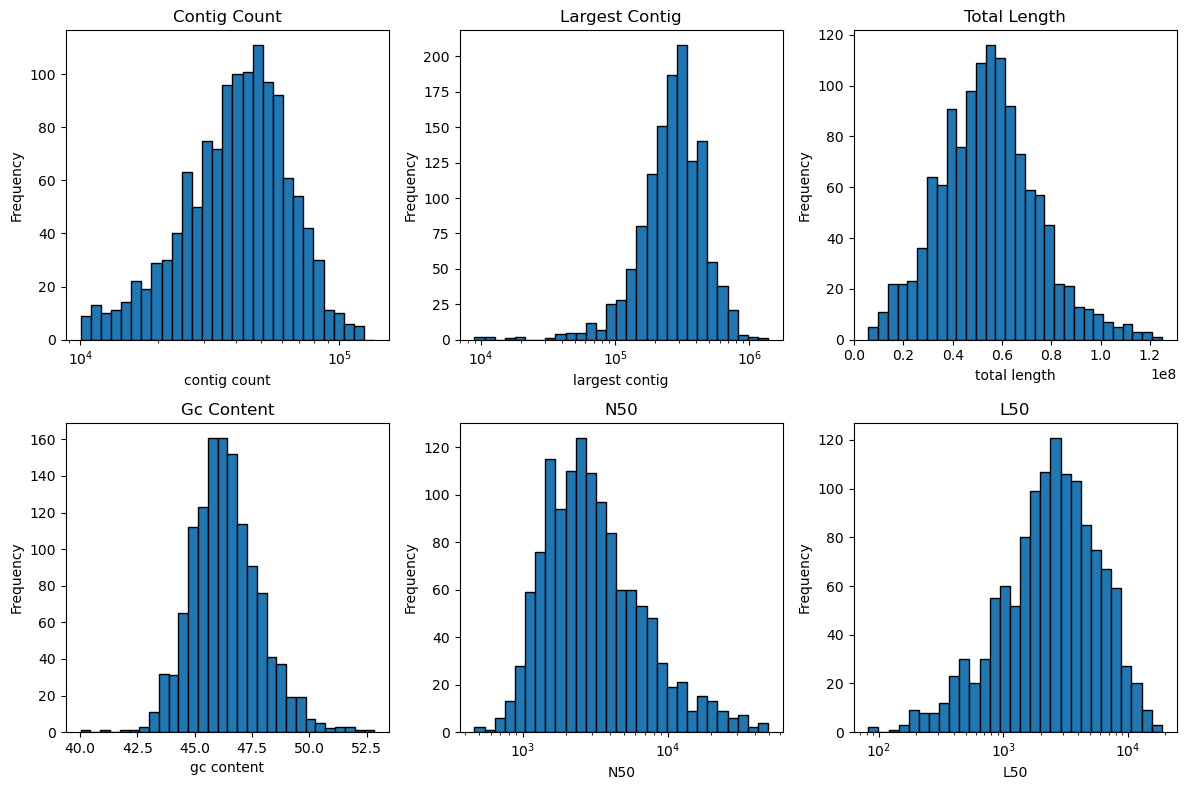

In [20]:

plt.figure(figsize=(12, 8))

log_scale_columns = ["contig_count", "largest_contig", "N50", "L50"]

for i, column in enumerate(["contig_count", "largest_contig", "total_length", "gc_content", "N50", "L50"], 1):
    plt.subplot(2, 3, i)
    data = filtered_stats_df[column].dropna()

    if column in log_scale_columns:
        data = data.replace(0, data[data > 0].min())
        bins = np.logspace(np.log10(data.min()), np.log10(data.max()), 30)
        plt.hist(data, bins=bins, edgecolor='black')
        plt.xscale('log')
    else:
        plt.hist(data, bins=30, edgecolor='black')

    plt.title(column.replace("_", " ").title())
    plt.xlabel(column.replace("_", " "))
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("contig_stats_histograms_filtered.png")
plt.show()

## Filter unusual medical status

In [73]:
# Step 1: Drop duplicate participants
sampled_df_unique = filtered_stats_df.drop_duplicates(subset="Participant ID")

# Step 2: Summary metadata per diagnosis
summary = sampled_df_unique.groupby("diagnosis").agg({
    "Participant ID": "count",
    "consent_age": ["mean", "std"],
    "Age at diagnosis": ["mean", "std"],
    "sex": lambda x: x.value_counts().to_dict(),
    "Antibiotics": lambda x: x.value_counts().to_dict(),
    "Chemotherapy": lambda x: x.value_counts().to_dict(),
    "Immunosuppressants (e.g. oral corticosteroids)": lambda x: x.value_counts().to_dict(),
    "6) Have you ever had bowel surgery?": lambda x: x.value_counts().to_dict()
})

# Flatten multi-index columns
summary.columns = [
    "Total Participants",
    "Mean Age", "Std Age",
    "Mean Age at Diagnosis", "Std Age at Diagnosis",
    "Sex Distribution", "Antibiotics", "Chemotherapy",
    "Immunosuppressants", "Bowel Surgery"
]

# Round numeric columns
numeric_cols = ["Mean Age", "Std Age", "Mean Age at Diagnosis", "Std Age at Diagnosis"]
summary[numeric_cols] = summary[numeric_cols].round(2)

# Transpose
summary_transposed = summary.T
summary_transposed.columns.name = None

# Step 3a: Site-level counts per diagnosis with total row
sites_pivot = sampled_df_unique.pivot_table(
    index="site_name",
    columns="diagnosis",
    values="Participant ID",
    aggfunc="count",
    fill_value=0
)
sites_row = pd.DataFrame(sites_pivot.sum()).T
sites_row.index = ["Sites"]
sites = pd.concat([sites_row, sites_pivot])
sites.loc["Sites"] = ""
sites = sites[summary_transposed.columns]

# Step 3b: Education Level per diagnosis with header
education_pivot = sampled_df_unique.groupby("diagnosis")["Education Level"].value_counts().unstack(fill_value=0).T
education_pivot.index.name = "Education Level"
edu_row = pd.DataFrame(["" for _ in range(education_pivot.shape[1])], index=education_pivot.columns).T
edu_row.index = ["Education"]
education = pd.concat([edu_row, education_pivot])
education = education[summary_transposed.columns]

# Step 3c: race
race_pivot = sampled_df_unique.groupby("diagnosis")["race"].value_counts().unstack(fill_value=0).T
race_pivot.index.name = "Race/Ethnicity"
race_row = pd.DataFrame(["" for _ in range(race_pivot.shape[1])], index=race_pivot.columns).T
race_row.index = ["Race/Ethnicity"]
race = pd.concat([race_row, race_pivot])
race = race[summary_transposed.columns]

# Step 4: Combine all into final table
combined = pd.concat([summary_transposed, sites, education, race])

# Show the final combined table
combined


,CD,UC,nonIBD
Total Participants,50,30,26
Mean Age,25.94,28.6,29.65
Std Age,16.83,17.65,20.45
Mean Age at Diagnosis,20.2,23.07,NaN
Std Age at Diagnosis,10.68,14.53,NaN
Sex Distribution,"{'Male': 27, 'Female': 23}","{'Female': 18, 'Male': 12}","{'Male': 15, 'Female': 11}"
Antibiotics,"{'No': 40, 'Yes': 10}",{'No': 30},"{'No': 25, 'Yes': 1}"
Chemotherapy,"{'No': 47, 'Yes': 3}","{'No': 29, 'Yes': 1}",{'No': 26}
Immunosuppressants,"{'No': 34, 'Yes': 16}","{'No': 26, 'Yes': 4}",{'No': 26}
Bowel Surgery,"{'No': 38, 'Yes': 11}",{'No': 28},{'No': 26}


In [74]:
# First, make sure the columns are standardized
cols = ["Antibiotics", "Chemotherapy", "Immunosuppressants (e.g. oral corticosteroids)", "6) Have you ever had bowel surgery?"]

# Create a binary DataFrame where 1 = 'Yes', 0 = 'No'
binary_df = filtered_stats_df[cols].applymap(lambda x: 1 if x == "Yes" else 0)

# Add a column to show how many categories each participant said 'Yes' to
binary_df["Total_Yes"] = binary_df.sum(axis=1)

# Show how many participants fall into each combination
overlap_counts = binary_df.value_counts().sort_index()

# Optional: reset index for easier viewing
overlap_summary = overlap_counts.reset_index(name="Count")
print(overlap_summary)


    Antibiotics  Chemotherapy  Immunosuppressants (e.g. oral corticosteroids)  \
0             0             0                                               0   
1             0             0                                               0   
2             0             0                                               1   
3             0             0                                               1   
4             0             1                                               0   
5             0             1                                               0   
6             0             1                                               1   
7             0             1                                               1   
8             1             0                                               0   
9             1             0                                               0   
10            1             0                                               1   
11            1             

In [141]:
# Step 1: Columns of interest
cols = ["Antibiotics", "Chemotherapy", "Immunosuppressants (e.g. oral corticosteroids)", "6) Have you ever had bowel surgery?"]
#cols = ["Antibiotics", "Chemotherapy"]
#cols = ["Antibiotics", "Chemotherapy","6) Have you ever had bowel surgery?"]
# Step 2: Convert to binary
binary_df = filtered_stats_df[cols].applymap(lambda x: 1 if x == "Yes" else 0)

# Step 3: Filter rows where all are 'No' (0)
filtered_no_yes = filtered_stats_df[~binary_df.any(axis=1)]

# Step 4: Create dropped2 with rows where any are 'Yes'
dropped2 = filtered_stats_df[binary_df.any(axis=1)]

# Optional: check counts
print(f"Kept (all No): {len(filtered_no_yes)}")
print(f"Dropped (any Yes): {len(dropped2)}")

Kept (all No): 914
Dropped (any Yes): 360


In [142]:
# Count of dropped samples per diagnosis
sample_counts = dropped2["diagnosis"].value_counts()

# Count of unique participants per diagnosis
participant_counts = dropped2.groupby("diagnosis")["Participant ID"].nunique()

# Combine into a summary DataFrame
dropped2_summary = pd.DataFrame({
    "Dropped Samples": sample_counts,
    "Dropped Participants": participant_counts
})

print(dropped2_summary)


        Dropped Samples  Dropped Participants
CD                  285                    41
UC                   59                    14
nonIBD               16                    10


ALL 4
Dropped Samples  Dropped Participants
CD                  285                    41
UC                   59                    14
nonIBD               16                    10

ANTIBIOTICS
        Dropped Samples  Dropped Participants
CD                   87                    26
UC                   14                     7
nonIBD               14                     9

## Check and filter by number of replicates

In [143]:

# Count of dropped samples per diagnosis
diagnosis_counts = filtered_no_yes.groupby("diagnosis")["External ID"].nunique()


# Count of unique participants per diagnosis
participant_counts = filtered_no_yes.groupby("diagnosis")["Participant ID"].nunique()

# Combine into a summary DataFrame
drop_summary = pd.DataFrame({
    "Samples": diagnosis_counts,
    "Participants": participant_counts
})

print(drop_summary)

           Samples  Participants
diagnosis                       
CD             283            36
UC             288            30
nonIBD         343            26


In [144]:
# Step 1: Count how many samples per participant
replicate_counts = filtered_no_yes["Participant ID"].value_counts()
min_replicates = replicate_counts.min()
min_replicates

1

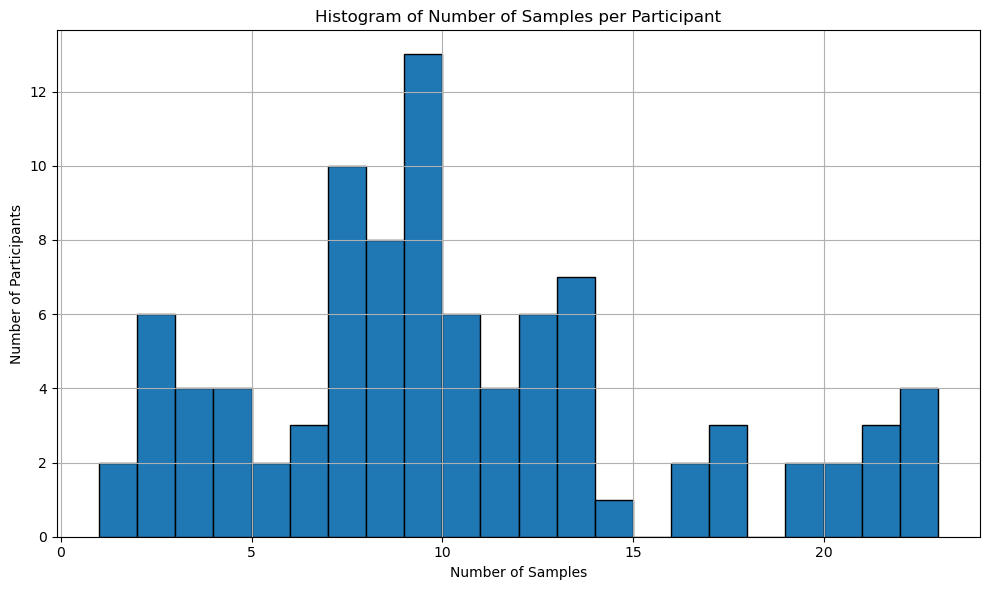

In [145]:
# Step 2: Plot histogram of number of samples per participant
plt.figure(figsize=(10, 6))
plt.hist(replicate_counts, bins=range(1, replicate_counts.max() + 2), edgecolor='black')
plt.title("Histogram of Number of Samples per Participant")
plt.xlabel("Number of Samples")
plt.ylabel("Number of Participants")
plt.grid(True)
plt.tight_layout()
plt.show()

In [152]:
# Step 2: Find participants with low replicates
low_rep_ids = replicate_counts[replicate_counts < 2].index.tolist()
print(len(low_rep_ids)) 

2


In [156]:
# Step 3: Filter the full sample_df (not just assembly_df) for those participants
low_rep_samples = filtered_no_yes[filtered_no_yes["Participant ID"].isin(low_rep_ids)]

# Step 4: Drop duplicates so each participant appears only once
low_rep_unique = low_rep_samples.drop_duplicates(subset="Participant ID")

In [157]:
# Step 2: Count how many participants fall into each diagnosis category
diagnosis_counts = low_rep_unique["diagnosis"].value_counts()

# Step 3: Print counts
print("Diagnosis counts (1 per participant) among participants with low replicates:")
print(f"UC: {diagnosis_counts.get('UC', 0)}")
print(f"CD: {diagnosis_counts.get('CD', 0)}")
print(f"nonIBD: {diagnosis_counts.get('nonIBD', 0)}")

Diagnosis counts (1 per participant) among participants with low replicates:
UC: 1
CD: 1
nonIBD: 0


after filtering out the replicate cutoff leads to…

Antibiotics(Abx)
+ 3x cutoff -> lose 0 participants
+ 5x cutoff -> lose 5 (4 CD, 1 UC)

Abx + Chemo
+ 3x cutoff -> lose 1 (1 CD)
+ 5x cutoff -> lose 8 (6 CD, 2 UC)

Abx + Chemo + bowel surgery
+ 3x cutoff -> lose 2 (2 CD)
+ 5x cutoff -> lose 9 (7 CD, 2 UC)

Abx + Chemo + bowel surgery + Immunosup.
+ 2x cutoff -> lose 2 (1 CD, 1 UC)
+ 3x cutoff -> lose 8 (4 CD, 4 UC)
+ 5x cutoff -> lose 16 (9 CD, 7 UC)


In [160]:
# Step 1: Count samples per participant
replicate_counts = filtered_no_yes["Participant ID"].value_counts()

# Step 2: Get list of participants with >5 samples
eligible_ids = replicate_counts[replicate_counts >= 2].index

# Step 3: Filter assembly_df for those participants only
filtered_df = filtered_no_yes[filtered_no_yes["Participant ID"].isin(eligible_ids)]

# Step 4: Randomly select 5 samples per participant
sampled_df = filtered_df.groupby("Participant ID").sample(n=2, random_state=42)

# Step 5 (optional): Reset index for clean output
sampled_df = sampled_df.reset_index(drop=True)

# Preview
sampled_df[["Participant ID", "External ID", "AssemblyName"]].head(20)
sampled_df[["Participant ID", "External ID", "AssemblyName"]]

,Participant ID,External ID,AssemblyName
0,C3003,CSM5MCWQ,CSM5MCWQ_contigs.fna.gz
1,C3003,CSM5FZ4M,CSM5FZ4M_contigs.fna.gz
2,C3004,CSM5MCXH,CSM5MCXH_contigs.fna.gz
3,C3004,CSM79HLI,CSM79HLI_contigs.fna.gz
4,C3005,CSM67UEM,CSM67UEM_contigs.fna.gz
...,...,...,...
175,P6035,PSMA264U,PSMA264U_contigs.fna.gz
176,P6037,PSMA269O,PSMA269O_contigs.fna.gz
177,P6037,PSMA266I,PSMA266I_contigs.fna.gz
178,P6038,PSMA266Y,PSMA266Y_contigs.fna.gz


## Save the metadata for the sampled_df

In [161]:
output_path = "SJBae/sampled_metadata_ACBI_2x.csv"
sampled_df.to_csv(output_path, index=False)

In [162]:
filtered_contig_stats = all_metadata_contig_stats[
    all_metadata_contig_stats["External ID"].isin(sampled_df["External ID"])
]

len(filtered_contig_stats)


180

In [163]:
filtered_contig_stats.to_csv("SJBae/sampled_metadata_contig_ACBI_2x.csv", index=False)